### Utilização de métricas mais informativas para avaliar modelos de classificação
Autor: Felipe Colombelli
```
```
GitHub: @colombelli

In [0]:
# Para carregar arquivos do drive, utilizamos as seguintes linhas de código

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Aqui importamos os dados de BRCA processados
# Fonte: Rahman M, Jackson LK, Johnson WE, Li DY et al. Alternative 
# preprocessing of RNA-Sequencing data in The Cancer Genome Atlas leads to 
# improved analysis results. Bioinformatics 2015 Nov 15;31(22):3666-72. 
# PMID: 26209429

import pandas as pd

normalDB = pd.read_csv('/content/drive/My Drive/Curso ML/Notebooks/Dados BRCA/procNormalSamples_log2.txt', sep="\t", header='infer')
# Lendo apenas 113 linhas dos pacientes com o tumor
tumorDB = pd.read_csv('/content/drive/My Drive/Curso ML/Notebooks/Dados BRCA/procTumorSamples_log2.txt', sep="\t", header='infer', nrows=113)

In [0]:

# Juntamos os dados e embaralhamos o dataframe
merged = pd.concat([normalDB, tumorDB])
merged = merged.sample(frac=1)

In [0]:
import tensorflow as tf

# Transformamos os dataframes em numpy arrays pegando apenas as partes que 
# interessam (o x e o y)
x = merged.loc[:, merged.columns != 'class']
x = x.values
y = merged.loc[:, ['class']].values
y = y.reshape((y.shape[0],))

# Seleção dos 10 atributos mais relevantes (segundo um teste chi²)
# Para otimizar o processo, pois temos 20mil features no x
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x_new = SelectKBest(chi2, k=10).fit_transform(x, y)
y_new = tf.keras.utils.to_categorical(y, 2) 
print(x_new.shape)

(226, 10)


In [0]:
# Utilização de 50 amostras para treinar a rede
# Obs: aqui foi só para que a rede não tivesse 100% de accuracy
# e fosse possível visualizar a matriz de confusão e curva ROC
# que normalmente vão ser encontradas (versões não perfeitas)

n_train = 50

x_train = x_new[0:n_train]
x_test = x_new[n_train:]
y_train = y_new[0:n_train]
y_test = y_new[n_train:]

In [0]:
# Construção e treinamento do modelo

import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(20, input_shape=(10,), activation=tf.nn.relu))  
model.add(tf.keras.layers.Dense(15, activation=tf.nn.relu))   
model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu)) 
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax)) 

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
             metrics=['accuracy'], optimizer=opt)  

model.fit(x_train, y_train, epochs=1, batch_size=6)

Train on 50 samples
50/50 [==============================] - 0s 4ms/sample - loss: 0.4274 - acc: 0.9000


In [0]:
# Avaliação do modelo

val_loss, val_acc = model.evaluate(x_test, y_test)

176/176 [==============================] - 0s 890us/sample - loss: 0.3512 - acc: 0.9375


In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# De OHE para classe inteira novamente
y_test_classes = np.argmax(y_test, axis=1)

# A confusion matrix construída pelo scikit-learn é estruturada
#
#                  #Classificados como Saudável  #Classificados como Doente
#                  |---------------------------|---------------------------|
# #Saudáveis reais |            TN             |           FP              |
#                  |---------------------------|---------------------------|  
# #Doentes reais   |            FN             |           TP              |
#                  |---------------------------|---------------------------|
#
# Ou mais genérico: eixo y: qtd real da classe; eixo x: qtd predita da classe
#
# TN: true negative - não tinham a doença e foram corretamente classificados
# FN: false negative - tinham a doença e foram classificados como saudáveis
# FP: false positive - não tinham a doença e foram classificados como doentes
# TP: true positive - tinham a doença e foram corretamente classificados

# Confution Matrix and Classification Report
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

cf = confusion_matrix(y_test_classes, y_pred)
print('Confusion Matrix')
print(cf)
print('\n\nClassification Report')
print(classification_report(y_test_classes, y_pred, target_names=['Saudável', 'Doente']))

Confusion Matrix
[[85  3]
 [ 8 80]]


Classification Report
              precision    recall  f1-score   support

    Saudável       0.91      0.97      0.94        88
      Doente       0.96      0.91      0.94        88

    accuracy                           0.94       176
   macro avg       0.94      0.94      0.94       176
weighted avg       0.94      0.94      0.94       176



In [0]:
# Pegando as probabilidades da classe positiva (1: "tem a doença")
# que serão utilizadas para na função roc_curve() do scikit-learn

pclass =[]
for pred in Y_pred:
  pclass.append(pred[1])
  
pclass = np.array(pclass)

In [0]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_classes, pclass)

In [0]:
# Cálculo da AUC

auc = roc_auc_score(y_test_classes, pclass)
print('AUC: %.3f' % auc)

AUC: 0.984


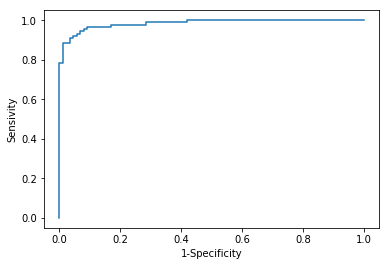

In [0]:
# Plot da curva ROC para o modelo proposto

pyplot.plot(fpr, tpr)
pyplot.xlabel('1-Specificity')
pyplot.ylabel('Sensivity')
pyplot.show()

In [0]:
# Thresholds testados:
thresholds
# Segundo a documentação do scikit-learn:
# thresholds[0] represents no instances being predicted 
# and is arbitrarily set to max(y_score) + 1.

array([1.8584425 , 0.8584425 , 0.56184274, 0.55702424, 0.52349657,
       0.5119216 , 0.50418067, 0.47764653, 0.47608408, 0.4664317 ,
       0.466205  , 0.46352327, 0.45032296, 0.44969168, 0.44265524,
       0.41887438, 0.41811356, 0.33089986, 0.31815535, 0.23747367,
       0.22346514, 0.18834393, 0.18806872, 0.05148457], dtype=float32)

In [0]:
print(tpr)
print("\n")
print(fpr)

[0.         0.01136364 0.78409091 0.78409091 0.88636364 0.88636364
 0.90909091 0.90909091 0.92045455 0.92045455 0.93181818 0.93181818
 0.94318182 0.94318182 0.95454545 0.95454545 0.96590909 0.96590909
 0.97727273 0.97727273 0.98863636 0.98863636 1.         1.        ]


[0.         0.         0.         0.01136364 0.01136364 0.03409091
 0.03409091 0.04545455 0.04545455 0.05681818 0.05681818 0.06818182
 0.06818182 0.07954545 0.07954545 0.09090909 0.09090909 0.17045455
 0.17045455 0.28409091 0.28409091 0.42045455 0.42045455 1.        ]
